<a href="https://colab.research.google.com/github/Gricay-vasily/project_9_DCGAN/blob/main/Learning_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Навчання Deep Convolutional Generative Adversarial Network (DCGAN) на завантажених даних Cifar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

2024-07-30 21:08:31.589528: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-30 21:08:31.643300: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-30 21:08:31.644452: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-30 21:08:32.603990: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.__version__

'2.13.1'

In [3]:
gpus = tf.config.list_physical_devices("GPU")

2024-07-30 21:08:35.427035: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-30 21:08:35.427991: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
if gpus:
    for gpu in gpus:
         print("Found a GPU with the name:", gpu)
else:
    print("Failed to detect a GPU.")

Failed to detect a GPU.


## Завантаження і підготовка Дата-сетів

### Зчитування мета-даних

Посилання на дані

In [5]:
URL_DIR = "https://www.cs.toronto.edu/~kriz/"
cifar=10

if cifar == 10:
    FILE_NAME_CIFAR = "cifar-10-python.tar.gz"
if cifar ==100:
    FILE_NAME_CIFAR = "cifar-100-python.tar.gz"

Завантажимо дані

In [6]:
def load_and_unzip_cifar(url:str, file_name:str):
  '''Завантаження і розпакування файлу-архіву, якщо ще цього не зроблено'''
  from pathlib import Path
  # Завантаження даних
  full_url_to_load = url + file_name
  print(full_url_to_load)
  if Path(file_name).exists() and Path(file_name).is_file():
    print(f"Файл {file_name} вже є. Немає потреби його завантажувати!")
  else:
    print(f"Заватажуємо файл {file_name} ")
    !wget $full_url_to_load
  # Розпакування даних
  # Створення робочої папки через stem i split - відсікання суфіксів
  work_dir = Path(str((Path() / Path(file_name).stem)).split(".")[0])
  # print(work_dir)
  if work_dir.exists() and work_dir.is_dir():
    print(f"Директорія {work_dir} вже існує, перезаписуємо файли")
    # Перезаписуємо, бо є файли, які не дають видалити папку
    !tar -xzvf $file_name
  else:
    print(f"Розпакуємо файл {file_name}")
    !tar -xzvf $file_name

load_and_unzip_cifar(URL_DIR, FILE_NAME_CIFAR)

https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Файл cifar-10-python.tar.gz вже є. Немає потреби його завантажувати!
Розпакуємо файл cifar-10-python.tar.gz
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [7]:
def unpickle(file):
  '''Десеріалізація даних з pickle-файлу'''
  import pickle
  with open(file, 'rb') as fo:
      dict = pickle.load(fo, encoding='bytes')
  return dict

In [8]:
if cifar == 10:
  print("Work with DB Cifar-10")
  metadata_path = './cifar-10-batches-py/batches.meta' # шлях до даних"
  metadata = unpickle(metadata_path)
  superclass_dict = dict(list(enumerate(metadata[b'label_names'])))
  
if cifar ==100:
  print("Work with DB Cifar-100")
  metadata_path = './cifar-100-python/meta' # шлях до даних
  metadata = unpickle(metadata_path)
  superclass_dict = dict(list(enumerate(metadata[b'coarse_label_names'])))

Work with DB Cifar-10


### Завантаження тренувальної та тестувальної вибірок (використовуючи суперкласи):

In [9]:
if cifar == 100:
  print("Work with DB Cifar-100")
  data_pre_path = './cifar-100-python/' # шлях до даних
  # шляхи до файлів
  data_train_path = data_pre_path + 'train'
  data_test_path = data_pre_path + 'test'
  # Зчитуємо словники
  data_train_dict = unpickle(data_train_path)
  data_test_dict = unpickle(data_test_path)
  # Отримуємо дані (вибираємо coarse_labels щоб отримати всі 100 класів)
  data_train = data_train_dict[b'data']
  label_train = np.array(data_train_dict[b'coarse_labels'])
  data_test = data_test_dict[b'data']
  label_test = np.array(data_test_dict[b'coarse_labels'])

### Завантаження тренувальної та тестувальної вибірок для Cifar-10:

In [10]:
if cifar == 10:
  print("Work with DB Cifar-10")
  data_pre_path = './cifar-10-batches-py/' # шлях до даних
  data_train = None
  label_train = []
  data_test = None
  label_test = []
  # Тренувальні вибірки
  for _ in range(1,6):
    data_train_dict = unpickle(data_pre_path + f"data_batch_{_}")
    if _ == 1:
      data_train = data_train_dict[b'data']
    else:
      data_train = np.vstack((data_train, data_train_dict[b'data']))
    label_train += data_train_dict[b'labels']
  #  Тестувальні вибірки
  data_test_dict = unpickle(data_pre_path + "test_batch")
  data_test = data_test_dict[b'data']
  label_test = data_test_dict[b'labels']

Work with DB Cifar-10


Поверхнево дослідимо дані

In [11]:
type(data_train.shape), type(data_test.shape)

(tuple, tuple)

In [12]:
data_train.shape, data_test.shape

((50000, 3072), (10000, 3072))

In [13]:
np.info(data_train)

class:  ndarray
shape:  (50000, 3072)
strides:  (3072, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7ff756d83010
byteorder:  little
byteswap:  False
type: uint8


In [14]:
data_train.reshape(len(data_train), 3, 32, 32).shape, data_test.reshape(len(data_test), 3, 32, 32).shape

((50000, 3, 32, 32), (10000, 3, 32, 32))

### Зміна розмірності зображень - виконувати лише раз у колабі!!!

In [15]:
np.info(data_train)

class:  ndarray
shape:  (50000, 3072)
strides:  (3072, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7ff756d83010
byteorder:  little
byteswap:  False
type: uint8


In [16]:
# Транспонується саме (0,2,3,1) - щоб отримати:
# 0 - Позицію картинки
# 2 - Значення висоти в пікселях
# 3 - Значення ширини в пікселях
# 1 - значення кольорів у RGB
# Якщо набрати (0,3,2,1) - картинка перевертається на 90град - висота і ширина міняються місцями

data_train = data_train.reshape(len(data_train), 3, 32, 32).transpose(0,2,3,1)
data_test = data_test.reshape(len(data_test), 3, 32, 32).transpose(0,2,3,1)

In [17]:
np.info(data_train)

class:  ndarray
shape:  (50000, 32, 32, 3)
strides:  (3072, 32, 1, 1024)
itemsize:  1
aligned:  True
contiguous:  False
fortran:  False
data pointer: 0x7ff756d83010
byteorder:  little
byteswap:  False
type: uint8


For picture #44717 - 4 (b'deer'):


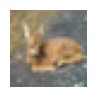

In [18]:
_ = random.randint(0,len(data_train))
print(f"For picture #{_} - {label_train[_]} ({superclass_dict[label_train[_]]}):")
fig = plt.figure(figsize=(1,1))
fig.add_subplot(1,1,1)
plt.imshow(data_train[_])
plt.axis("off")
plt.show()

Трохи більше картинок з тренувальної та тестувальної вибірок...

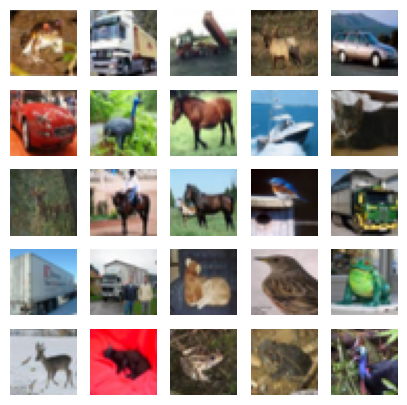

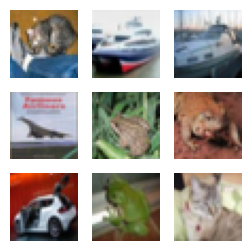

In [19]:
def show_pictures_n_m(data,n,m:int):
    fig = plt.figure(figsize=(max(n,m),max(n,m)))
    for _ in range (n*m):
        fig.add_subplot(n,m,_+1)
        plt.imshow(data[_])
        plt.axis("off")
    plt.show()

show_pictures_n_m(data_train,5,5)
show_pictures_n_m(data_test,3,3)

### Подальша підготовка даних для тренувань мережі

In [20]:
data_train.shape[0]

50000

In [21]:
BUFFER_SIZE = data_train.shape[0]
BATCH_SIZE = 256
# як альтернатива
# BATCH_SIZE = int(BUFFER_SIZE / 100)

In [22]:
def prepare_images(data_set, buffer_size, batch_size):
  prepared_images = data_set.astype("float32")
  prepared_images = (prepared_images - 127.5) / 127.5
  # prepared_images = prepared_images[:1000]
  # prepared_images = tf.data.Dataset.from_tensor_slices(prepared_images)
  # Перемішаємо дані випадковим чином
  # prepared_images = prepared_images.shuffle(buffer_size=buffer_size).batch(batch_size=batch_size)
  return prepared_images

In [23]:
train_images = prepare_images(data_train, BUFFER_SIZE, BATCH_SIZE)

In [24]:
train_images.shape

(50000, 32, 32, 3)

In [25]:
np.info(train_images)

class:  ndarray
shape:  (50000, 32, 32, 3)
strides:  (12288, 128, 4, 4096)
itemsize:  4
aligned:  True
contiguous:  False
fortran:  False
data pointer: 0x7ff706c1e010
byteorder:  little
byteswap:  False
type: float32


In [26]:
train_images[0]

array([[[-0.5372549 , -0.5137255 , -0.5058824 ],
        [-0.6627451 , -0.6392157 , -0.64705884],
        [-0.60784316, -0.62352943, -0.6627451 ],
        ...,
        [ 0.23921569,  0.03529412, -0.15294118],
        [ 0.19215687, -0.01960784, -0.2       ],
        [ 0.16078432, -0.02745098, -0.19215687]],

       [[-0.8745098 , -0.84313726, -0.84313726],
        [-1.        , -1.        , -1.        ],
        [-0.85882354, -0.9372549 , -1.        ],
        ...,
        [-0.03529412, -0.30980393, -0.5686275 ],
        [-0.06666667, -0.34901962, -0.60784316],
        [-0.04313726, -0.31764707, -0.5529412 ]],

       [[-0.8039216 , -0.8117647 , -0.8352941 ],
        [-0.8745098 , -0.94509804, -1.        ],
        [-0.6156863 , -0.7882353 , -0.9372549 ],
        ...,
        [-0.07450981, -0.34117648, -0.60784316],
        [-0.05882353, -0.34117648, -0.60784316],
        [-0.14509805, -0.42745098, -0.67058825]],

       ...,

       [[ 0.6313726 ,  0.33333334, -0.24705882],
        [ 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


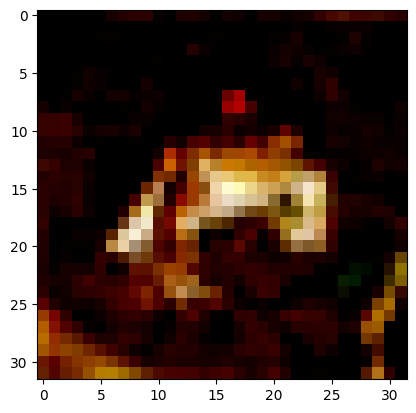

In [27]:
plt.imshow(train_images[0])

In [28]:
BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = min(256, int(BUFFER_SIZE / 100))

# Створення та тренування генератора і дискримінатора

Генератор - використовує шари `tf.keras.layers.Conv2DTranspose` (для підвищення дискретності),щоб створювати зображення з вихідного випадкового шуму (random noise). Починається шаром `Dense`, який приймає це початкове значення, а потім кілька разів підвищує дискретизацію, поки не досягне бажаного розміру зображення.

Дискримінатор - Це класифікатор зображень на основі CNN.

Він класифікує (визначає) якою є згенерована картинка - справжньою чи фейковою. Модель тренується показувати позитивне значення для справжньої картинки і негативне для фейкової.

In [29]:
def real_or_fake(decision):
  if decision>=0:
    return "Real"
  else:
    return "Fake"

## Змінні

In [30]:
# Швидкість навчання
LEARNING_RATE = 0.0005
# Вхідна розмірність
INPUT_DIM = 100

## Функції створення генератора та дискримінатора

In [31]:
def build_generator(nodes=4, input_dim=100, alpha = 0.2):
  """Створення генератора"""
  model = models.Sequential(name = "Genegator")
  # Основа для зображення 4 * 4 * 256
  n_f_nodes = 256 * nodes * nodes
  model.add(layers.Dense(n_f_nodes, input_dim = input_dim))
  # model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha = alpha))
  model.add(layers.Reshape((nodes, nodes, 256)))
  # Підвищення дискретизації до 8x8
  # model.add(layers.BatchNormalization())
  model.add(layers.Conv2DTranspose(128, (nodes, nodes), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU(alpha = alpha))
  # Підвищення дискретизації до 16x16
  # model.add(layers.BatchNormalization())
  model.add(layers.Conv2DTranspose(128, (nodes, nodes), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU(alpha = alpha))
  # Підвищення дискретизації до 32x32
  # model.add(layers.BatchNormalization())
  model.add(layers.Conv2DTranspose(128, (nodes, nodes), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU(alpha = alpha))
  # Вихідний шар
  model.add(layers.Conv2D(3, (3, 3), activation='tanh', padding='same'))

  print("Створено Генератор")
  return model

In [32]:
def build_discriminator(input_shape = (32,32,3), alpha = 0.2):
  """Створення дискримінатора"""
  model = models.Sequential(name = "Discriminator")
  # Перший шар
  model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
  model.add(layers.LeakyReLU(alpha=alpha))
  # model.add(layers.Dropout(0.3))
  # 3меншення дискретизації
  model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU(alpha=alpha))
  # model.add(layers.Dropout(0.3))
  # 3меншення дискретизації
  model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU(alpha=alpha))
  # model.add(layers.Dropout(0.3))
  # 3меншення дискретизації
  model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU(alpha=alpha))
  # model.add(layers.Dropout(0.3))
  # Класифікатор
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(1, activation='sigmoid'))

  print("Створено Дискримінатор")
  return model

In [33]:
def build_gen_disc_model(gen_model, disc_model):
  '''
  Комбінована модель генератора і дискримінатора,
  для оновлення генератора
  '''
  # зробимо ваги для дискримінатора нетренованими
  disc_model.trainable = False
  # З'єднаємо дві моделі
  model = models.Sequential(name = "G_and_D")
  # Додамо генератор
  model.add(gen_model)
  # Додамо дискримінатор
  model.add(disc_model)

  print("Створено Генератор-Дискримінатор")
  return model

In [34]:
def compile_model(model, opt, loss, metrics):
  '''Компіляція створеної моделі'''
  model.compile(loss = loss, optimizer = opt, metrics = metrics)
  print("Модель скомпільовано")

## Функції роботи генератора

In [35]:
def generate_real_images(dataset, n_images):
  '''Генерація реальних зображень'''
  # Виберемо випадкове зображення
  idx = np.random.randint(0, dataset.shape[0], n_images)
  # print(f"Func = g_r_i, idx = {idx}")
  # print(f"Func = g_r_i, idx.shape = {idx.shape}")
  # Отримаємо вибрані зображення
  X = dataset[idx]
  # print(f"Func = g_r_i, X = {X}")
  # print(f"Func = g_r_i, X.shape = {X.shape}")
  # Згенеруємо 'справжні' мітки класу - одинична матриця
  y = np.ones((n_images, 1))
  # print(f"Func = g_r_i, y = {y}")
  # print(f"Func = g_r_i, y.shape = {y.shape}")
  return X, y

In [36]:
X, y = generate_real_images(train_images, 100)

In [37]:
X.shape

(100, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


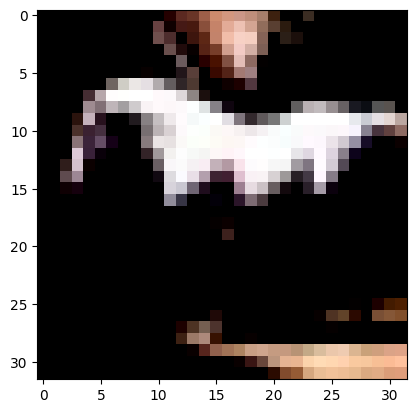

In [38]:
plt.imshow(X[3])

In [39]:
def generate_points(input_dim, n_images):
  '''
  Генерація точок в прихованому вхідному шарі просторі
  як вхідні дані для генератора
  '''
  # Генерація точок
  x_input = np.random.randn(input_dim * n_images)
  # print(f"Func = g_p, x_input.shape = {x_input.shape}")
  # Зміна форми до форми пакету виходів мережі
  x_input = x_input.reshape(n_images, input_dim)
  # print(f"Func = g_p, x_input.reshape = {x_input.shape}")
  return x_input

In [40]:
def generate_fake_images(gen_model, input_dim, n_images):
  '''Генерація фейкових зображень'''
  # Генеруємо точки для вхідного шару
  x_input = generate_points(input_dim, n_images)
  # print(f"Func = g_f_i, x_input.shape = {x_input.shape}")
  # Генерація (передбачення) генератором
  X = gen_model.predict(x_input, verbose = 0)
  # print(f"Func = g_f_i, X_input.shape = {X.shape}")
  # Створення 'фейкового зображення' - матриця нулів
  y = np.zeros((n_images, 1))
  # print(f"Func = g_f_i, y.shape = {y.shape})")
  return X, y


## Функції обробки результатів роботи моделей

In [41]:
def show_save_plot(examples, epoch, to_save, n=5):
  '''
  Створення, вивід та за необхідності збереження зображень
  '''
  # Масштабування виводу зображення (від [-1,1] до [0,1])
  examples = (examples + 1) / 2.0
  # Малювання зображень
  for i in range(n * n):
      plt.subplot(n, n, 1 + i)
      # Приберемо виведення осей
      plt.axis('off')
      # Вивід зображення
      plt.imshow(examples[i])
  # Збереження зображення за необхідності
  if to_save:
    filename = "gen_img_e%03d.png" % (epoch+1)
    plt.savefig(filename)
  plt.show()

In [42]:
def summary_performance(epoch, gen_model, disc_model, dataset, input_dim, n_images=100, to_save = False):
  '''
  Ф-я оцінки дискримінатором, побудова зображень
  '''
  # Генерація реальних зображень
  # print("Func =s_p_i, Генерація реальних зображень")
  X_real, y_real = generate_real_images(dataset, n_images)
  # Оцінка дискримінатором згенерованих реальних зображень
  # print("Func =s_p_i, Оцінка дискримінатором згенерованих реальних зображень")
  _, accuracy_real = disc_model.evaluate(X_real, y_real, verbose=0)
  # Генерація фейкових зображень
  # print("Func =s_p_i, Генерація фейкових зображень")
  x_fake, y_fake = generate_fake_images(gen_model, input_dim, n_images)
  # Оцінка дискримінатором згенерованих фейкових зображень
  # print("Func =s_p_i, Оцінка дискримінатором згенерованих фейкових зображень")
  _, accuracy_fake = disc_model.evaluate(x_fake, y_fake, verbose=0)
  # Загальний вивід інформації роботи дискримінатора
  # print("Func =s_p_i, Загальний вивід інформації роботи дискримінатора")
  print(f"Точність для реального зображення: {accuracy_real*100 : .0f}\n\
Точність для фейкового зображення {accuracy_fake * 100:.0f}")
  show_save_plot(x_fake, epoch, to_save = to_save)
  if to_save:
    filename = "generator_e%03d.h5" % (epoch+1)
    gen_model.save(filename)
    filename = "discriminator_e%03d.h5" % (epoch+1)
    disc_model.save(filename)

## Функція тренування генератора і дискримінатора

In [43]:
def train(gen_model, disc_model, gen_disc_model, dataset, input_dim, n_epochs, batch_size, to_save = False):
  '''Функція тренування генератора і дискримінатора'''
  from IPython import display
  import time as tm
  
  start = tm.time()
  # Кількість пакетів на епоху
  batch_per_epoch = int(dataset.shape[0] / batch_size)
  half_batch = int(batch_size / 2)
  # Ручний перелік епох
  new_leanring_rate = disc_model.optimizer.learning_rate.numpy()
  
  for i in range(n_epochs):
    if (i+1) % int(n_epochs/10) == 0 and i != 0:
      new_leanring_rate = disc_model.optimizer.learning_rate.numpy()/2
      if new_leanring_rate <= 1e-4:
        new_leanring_rate = 1e-4
      # gen_model.optimizer = Adam(learning_rate=new_leanring_rate)
      disc_model.optimizer = Adam(learning_rate=new_leanring_rate)
      gen_disc_model.optimizer = Adam(learning_rate=new_leanring_rate)
    
    ep_start = tm.time()
    print(f"Епоха {i+1} з {n_epochs}")
    print(f"LEARNING_RATE={new_leanring_rate:.5f}")
    
    # Перелік пакетів у тренувальній вибірці
    for j in range(batch_per_epoch):
      # Випадкова генерація 'реальних' зображень
      # print("Випадкова генерація 'реальних' зображень")
      X_real, y_real = generate_real_images(dataset, half_batch)
      # Оновлення вагів дискримінатора для 'реальних' зображень
      # print("Оновлення вагів дискримінатора для 'реальних' зображень")
      d_loss1, _ = disc_model.train_on_batch(X_real, y_real)
      # Генерація 'фейкових' зображень
      # print("Генерація 'фейкових' зображень")
      X_fake, y_fake = generate_fake_images(gen_model, input_dim, half_batch)
      # Оновлення вагів дискримінатора для 'фейкових' зображень
      # print("Оновлення вагів дискримінатора для 'фейкових' зображень")
      d_loss2, _ = disc_model.train_on_batch(X_fake, y_fake)
      # Підготовка точок у вхідному шарі як вхідних для генератора
      # print("Підготовка точок у вхідному шарі як вхідних для генератора")
      X_gen_disc = generate_points(input_dim, batch_size)
      # Створення інвертованих міток для фейкових зображень
      # print("Створення інвертованих міток для фейкових зображень")
      y_gen_disc = np.ones((batch_size, 1))
      # Оновлення генератора через значення помилок дискримінатора
      # print("Оновлення ваг генератора через значення помилок дискримінатора")
      gen_disc_loss = gen_disc_model.train_on_batch(X_gen_disc, y_gen_disc)
      
      # Загальна втрата для цього пакету
      if (j+1) % int(batch_per_epoch/10) == 0 and j != 0:
        print("Ep=%d, J=%d/%d, d_loss1=%.3f, d_loss2=%.3f, gan_loss=%.3f" % (i+1, j+1, batch_per_epoch, d_loss1, d_loss2, gen_disc_loss))
    
    # Проміжна оцінка продуктивності моделі
    # if (i+1) % int(n_epochs/10) == 0 and i != 0:
    summary_performance(i, gen_model, disc_model, dataset, input_dim, to_save=to_save)
    print(f"Час навчання епохи {i+1} - {(tm.time()-ep_start):.2f} сек")
  
  print(f"Загальний час навчання на {n_epochs} епохах - {(tm.time()-start):.2f} сек")

## Створення і налаштування генератора

In [44]:
LOSS = "binary_crossentropy"
OPT = Adam(learning_rate=LEARNING_RATE, beta_1=0.5)
METRICS = []

generator = build_generator(nodes=4, input_dim=100, alpha = 0.2)
compile_model(generator, OPT, LOSS, METRICS)

generator.summary()

Створено Генератор
Модель скомпільовано
Model: "Genegator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         524416    
 anspose)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 128)       262272    
 Transpose)      

In [ ]:
plot_model(generator, to_file="generator.png",
            show_shapes=True,
            show_dtype=True,
            show_layer_names=True,
            rankdir="TB",
            expand_nested=True,
            dpi=96,
            layer_range=None,
            show_layer_activations=True,
            show_trainable=True,
)

## Створення і налаштування дискримінатора

In [45]:
LOSS = "binary_crossentropy"
OPT = Adam(learning_rate=LEARNING_RATE, beta_1=0.5)
METRICS = ["accuracy"]

discriminator = build_discriminator(input_shape = (32,32,3), alpha = 0.2)
compile_model(discriminator, OPT, LOSS, METRICS)

discriminator.summary()

Створено Дискримінатор
Модель скомпільовано
Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_4

## Створення і налаштування загальної моделі генератор-дискримінатор

In [ ]:
plot_model(discriminator, to_file="discriminator.png",
            show_shapes=True,
            show_dtype=True,
            show_layer_names=True,
            rankdir="TB",
            expand_nested=True,
            dpi=96,
            layer_range=None,
            show_layer_activations=True,
            show_trainable=True,
)

In [46]:
LOSS = "binary_crossentropy"
OPT = Adam(learning_rate=LEARNING_RATE, beta_1=0.5)
METRICS = []

gen_disc = build_gen_disc_model(generator, discriminator)
compile_model(gen_disc, OPT, LOSS, METRICS)

gen_disc.summary()

Створено Генератор-Дискримінатор
Модель скомпільовано
Model: "G_and_D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Genegator (Sequential)      (None, 32, 32, 3)         1466115   
                                                                 
 Discriminator (Sequential)  (None, 1)                 522497    
                                                                 
Total params: 1988612 (7.59 MB)
Trainable params: 1466115 (5.59 MB)
Non-trainable params: 522497 (1.99 MB)
_________________________________________________________________


In [ ]:
plot_model(gen_disc, to_file="gen_disc.png",
            show_shapes=True,
            show_dtype=True,
            show_layer_names=True,
            rankdir="TB",
            expand_nested=True,
            dpi=96,
            layer_range=None,
            show_layer_activations=True,
            show_trainable=True,
)

generated_image.shape = (1, 32, 32, 3)
Точність decision = 0.49996164441108704
Зображення - Real


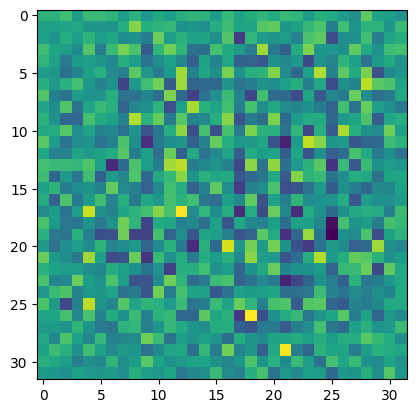

In [47]:
# Генерування зображення та його класифікація дискримінатором без навчання
noise = tf.random.normal([1, INPUT_DIM])
generated_image = generator(noise, training = False)
decision = discriminator(generated_image).numpy()[0][0]
print(f"generated_image.shape = {generated_image.shape}") #TensorShape([1, 32, 32, 3])
print(f"Точність decision = {decision}")
verdict = real_or_fake(decision)
print(f"Зображення - {verdict}")
plt.imshow(generated_image[generated_image.shape[0]-1, :,: ,0])
plt.show()

## Тренування моделей

Задаємо тренувальні параметри

In [48]:
EPOCHS = 20

In [49]:
np.info(train_images)

class:  ndarray
shape:  (50000, 32, 32, 3)
strides:  (12288, 128, 4, 4096)
itemsize:  4
aligned:  True
contiguous:  False
fortran:  False
data pointer: 0x7ff706c1e010
byteorder:  little
byteswap:  False
type: float32


Епоха 1 з 20
LEARNING_RATE=0.00050
Ep=1, J=19/195, d_loss1=0.001, d_loss2=1.527, gan_loss=4.670
Ep=1, J=38/195, d_loss1=0.657, d_loss2=0.036, gan_loss=2.941
Ep=1, J=57/195, d_loss1=0.223, d_loss2=0.193, gan_loss=4.474
Ep=1, J=76/195, d_loss1=0.364, d_loss2=0.072, gan_loss=3.711
Ep=1, J=95/195, d_loss1=0.101, d_loss2=0.058, gan_loss=3.921
Ep=1, J=114/195, d_loss1=0.502, d_loss2=0.336, gan_loss=4.039
Ep=1, J=133/195, d_loss1=0.449, d_loss2=0.080, gan_loss=4.146
Ep=1, J=152/195, d_loss1=0.237, d_loss2=0.191, gan_loss=3.393
Ep=1, J=171/195, d_loss1=0.750, d_loss2=0.622, gan_loss=1.860
Ep=1, J=190/195, d_loss1=0.467, d_loss2=0.657, gan_loss=1.417
Точність для реального зображення:  75
Точність для фейкового зображення 89


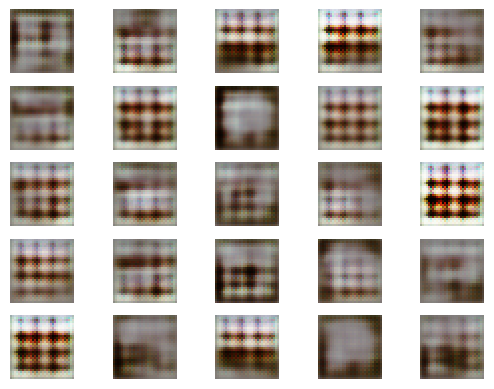

/home/vasily/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Час навчання епохи 1 - 345.28 сек
Епоха 2 з 20
LEARNING_RATE=0.00025
Ep=2, J=19/195, d_loss1=0.595, d_loss2=0.749, gan_loss=1.654
Ep=2, J=38/195, d_loss1=0.459, d_loss2=0.230, gan_loss=2.400
Ep=2, J=57/195, d_loss1=0.522, d_loss2=0.498, gan_loss=1.172
Ep=2, J=76/195, d_loss1=0.639, d_loss2=0.532, gan_loss=1.754
Ep=2, J=95/195, d_loss1=0.636, d_loss2=0.478, gan_loss=1.509
Ep=2, J=114/195, d_loss1=0.729, d_loss2=0.487, gan_loss=1.475
Ep=2, J=133/195, d_loss1=0.454, d_loss2=0.547, gan_loss=1.434
Ep=2, J=152/195, d_loss1=0.406, d_loss2=0.427, gan_loss=2.677
Ep=2, J=171/195, d_loss1=0.623, d_loss2=0.562, gan_loss=1.148
Ep=2, J=190/195, d_loss1=0.570, d_loss2=0.532, gan_loss=1.569
Точність для реального зображення:  68
Точність для фейкового зображення 78


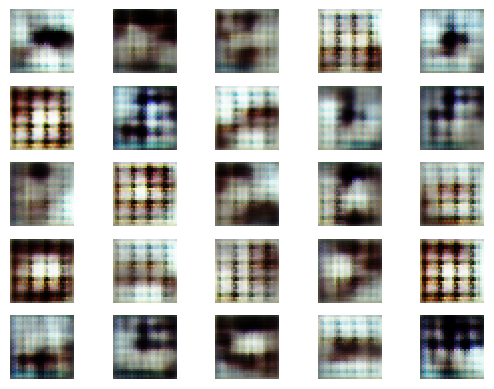

Час навчання епохи 2 - 358.80 сек
Епоха 3 з 20
LEARNING_RATE=0.00025
Ep=3, J=19/195, d_loss1=0.888, d_loss2=0.716, gan_loss=1.437
Ep=3, J=38/195, d_loss1=0.607, d_loss2=0.549, gan_loss=1.188
Ep=3, J=57/195, d_loss1=0.578, d_loss2=0.534, gan_loss=1.447
Ep=3, J=76/195, d_loss1=0.531, d_loss2=0.524, gan_loss=1.478
Ep=3, J=95/195, d_loss1=0.626, d_loss2=0.577, gan_loss=1.329
Ep=3, J=114/195, d_loss1=0.653, d_loss2=0.610, gan_loss=1.249
Ep=3, J=133/195, d_loss1=0.477, d_loss2=0.491, gan_loss=1.672
Ep=3, J=152/195, d_loss1=0.588, d_loss2=0.633, gan_loss=1.287
Ep=3, J=171/195, d_loss1=0.650, d_loss2=0.546, gan_loss=1.353
Ep=3, J=190/195, d_loss1=0.674, d_loss2=0.624, gan_loss=1.423
Точність для реального зображення:  70
Точність для фейкового зображення 69


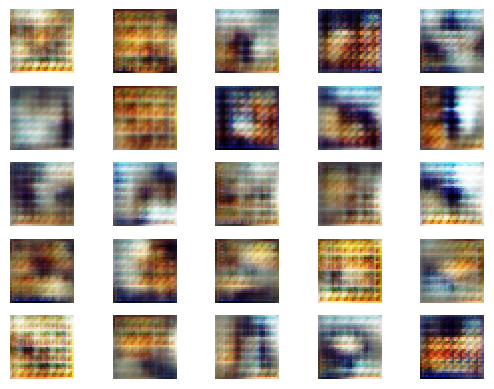

Час навчання епохи 3 - 338.62 сек
Епоха 4 з 20
LEARNING_RATE=0.00013
Ep=4, J=19/195, d_loss1=0.423, d_loss2=0.724, gan_loss=0.978
Ep=4, J=38/195, d_loss1=0.902, d_loss2=0.567, gan_loss=1.605
Ep=4, J=57/195, d_loss1=0.647, d_loss2=0.603, gan_loss=1.325
Ep=4, J=76/195, d_loss1=0.550, d_loss2=0.522, gan_loss=1.242
Ep=4, J=95/195, d_loss1=0.390, d_loss2=0.478, gan_loss=1.619
Ep=4, J=114/195, d_loss1=0.774, d_loss2=0.541, gan_loss=1.408
Ep=4, J=133/195, d_loss1=0.493, d_loss2=0.640, gan_loss=1.072
Ep=4, J=152/195, d_loss1=0.627, d_loss2=0.633, gan_loss=1.400
Ep=4, J=171/195, d_loss1=0.541, d_loss2=0.584, gan_loss=1.334
Ep=4, J=190/195, d_loss1=0.426, d_loss2=0.587, gan_loss=1.428
Точність для реального зображення:  54
Точність для фейкового зображення 75


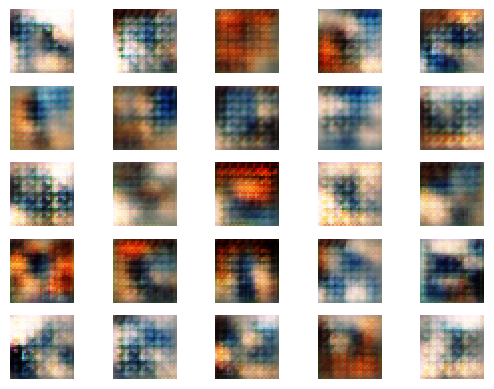

Час навчання епохи 4 - 355.23 сек
Епоха 5 з 20
LEARNING_RATE=0.00013
Ep=5, J=19/195, d_loss1=0.598, d_loss2=0.574, gan_loss=1.759
Ep=5, J=38/195, d_loss1=0.536, d_loss2=0.553, gan_loss=1.541
Ep=5, J=57/195, d_loss1=0.834, d_loss2=0.821, gan_loss=1.377
Ep=5, J=76/195, d_loss1=0.481, d_loss2=0.514, gan_loss=1.490
Ep=5, J=95/195, d_loss1=0.550, d_loss2=0.397, gan_loss=1.514
Ep=5, J=114/195, d_loss1=0.386, d_loss2=0.421, gan_loss=2.002
Ep=5, J=133/195, d_loss1=0.663, d_loss2=0.608, gan_loss=1.398
Ep=5, J=152/195, d_loss1=0.646, d_loss2=0.475, gan_loss=1.299
Ep=5, J=171/195, d_loss1=0.588, d_loss2=0.761, gan_loss=1.305
Ep=5, J=190/195, d_loss1=0.748, d_loss2=0.383, gan_loss=1.523
Точність для реального зображення:  62
Точність для фейкового зображення 89


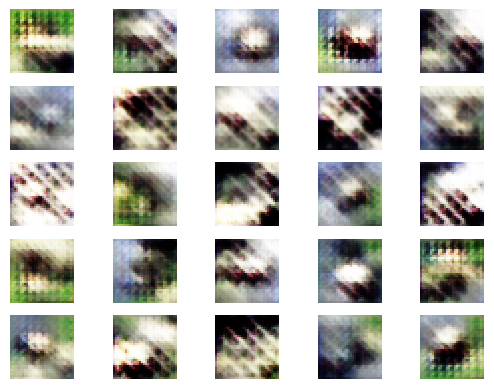

Час навчання епохи 5 - 358.47 сек
Епоха 6 з 20
LEARNING_RATE=0.00010
Ep=6, J=19/195, d_loss1=0.370, d_loss2=0.425, gan_loss=1.606
Ep=6, J=38/195, d_loss1=0.452, d_loss2=0.400, gan_loss=1.726
Ep=6, J=57/195, d_loss1=0.618, d_loss2=0.521, gan_loss=1.709
Ep=6, J=76/195, d_loss1=0.575, d_loss2=0.542, gan_loss=2.068
Ep=6, J=95/195, d_loss1=0.495, d_loss2=0.633, gan_loss=1.766
Ep=6, J=114/195, d_loss1=0.515, d_loss2=0.581, gan_loss=1.515
Ep=6, J=133/195, d_loss1=0.584, d_loss2=0.598, gan_loss=1.304
Ep=6, J=152/195, d_loss1=0.565, d_loss2=0.512, gan_loss=1.370
Ep=6, J=171/195, d_loss1=0.605, d_loss2=0.459, gan_loss=1.602
Ep=6, J=190/195, d_loss1=0.522, d_loss2=0.601, gan_loss=1.420
Точність для реального зображення:  55
Точність для фейкового зображення 78


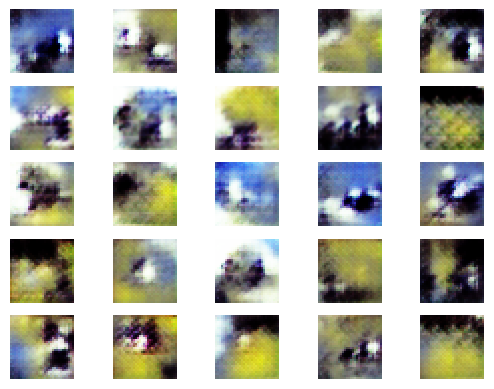

Час навчання епохи 6 - 360.74 сек
Епоха 7 з 20
LEARNING_RATE=0.00010
Ep=7, J=19/195, d_loss1=0.557, d_loss2=0.450, gan_loss=1.585
Ep=7, J=38/195, d_loss1=0.661, d_loss2=0.513, gan_loss=1.889
Ep=7, J=57/195, d_loss1=0.505, d_loss2=0.606, gan_loss=1.182
Ep=7, J=76/195, d_loss1=0.601, d_loss2=0.562, gan_loss=1.399
Ep=7, J=95/195, d_loss1=0.679, d_loss2=0.517, gan_loss=1.637
Ep=7, J=114/195, d_loss1=0.564, d_loss2=0.562, gan_loss=1.244
Ep=7, J=133/195, d_loss1=0.381, d_loss2=0.588, gan_loss=1.327
Ep=7, J=152/195, d_loss1=0.854, d_loss2=0.519, gan_loss=1.219
Ep=7, J=171/195, d_loss1=0.492, d_loss2=0.516, gan_loss=1.394
Ep=7, J=190/195, d_loss1=0.674, d_loss2=0.591, gan_loss=1.109
Точність для реального зображення:  58
Точність для фейкового зображення 92


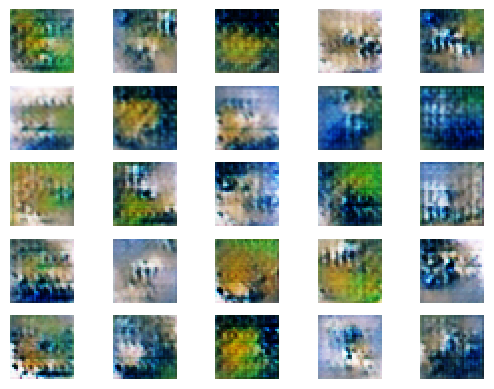

Час навчання епохи 7 - 365.60 сек
Епоха 8 з 20
LEARNING_RATE=0.00010
Ep=8, J=19/195, d_loss1=0.641, d_loss2=0.511, gan_loss=1.274
Ep=8, J=38/195, d_loss1=0.465, d_loss2=0.510, gan_loss=1.497
Ep=8, J=57/195, d_loss1=0.638, d_loss2=0.657, gan_loss=1.185
Ep=8, J=76/195, d_loss1=0.436, d_loss2=0.406, gan_loss=1.616
Ep=8, J=95/195, d_loss1=0.696, d_loss2=0.581, gan_loss=1.279
Ep=8, J=114/195, d_loss1=0.620, d_loss2=0.616, gan_loss=1.475
Ep=8, J=133/195, d_loss1=0.651, d_loss2=0.504, gan_loss=1.225
Ep=8, J=152/195, d_loss1=0.546, d_loss2=0.542, gan_loss=1.410
Ep=8, J=171/195, d_loss1=0.601, d_loss2=0.567, gan_loss=1.366
Ep=8, J=190/195, d_loss1=0.726, d_loss2=0.714, gan_loss=1.361
Точність для реального зображення:  81
Точність для фейкового зображення 86


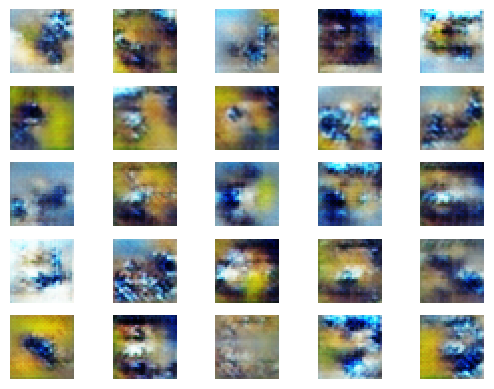

Час навчання епохи 8 - 376.18 сек
Епоха 9 з 20
LEARNING_RATE=0.00010
Ep=9, J=19/195, d_loss1=0.674, d_loss2=0.546, gan_loss=1.323
Ep=9, J=38/195, d_loss1=0.629, d_loss2=0.508, gan_loss=1.606
Ep=9, J=57/195, d_loss1=0.629, d_loss2=0.566, gan_loss=1.372
Ep=9, J=76/195, d_loss1=0.523, d_loss2=0.745, gan_loss=1.858
Ep=9, J=95/195, d_loss1=0.813, d_loss2=0.348, gan_loss=1.918
Ep=9, J=114/195, d_loss1=0.645, d_loss2=0.568, gan_loss=1.380
Ep=9, J=133/195, d_loss1=0.718, d_loss2=0.708, gan_loss=1.640
Ep=9, J=152/195, d_loss1=0.648, d_loss2=0.553, gan_loss=1.171
Ep=9, J=171/195, d_loss1=0.679, d_loss2=0.578, gan_loss=1.362
Ep=9, J=190/195, d_loss1=0.568, d_loss2=0.531, gan_loss=1.344
Точність для реального зображення:  64
Точність для фейкового зображення 93


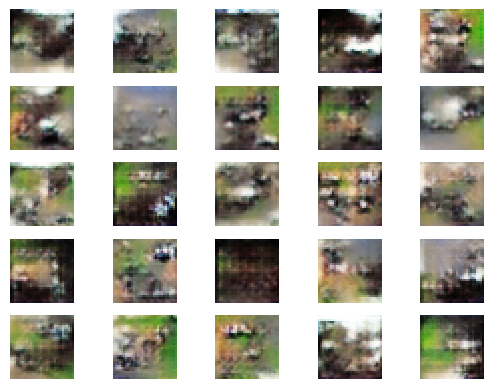

Час навчання епохи 9 - 355.52 сек
Епоха 10 з 20
LEARNING_RATE=0.00010
Ep=10, J=19/195, d_loss1=0.658, d_loss2=0.511, gan_loss=1.610
Ep=10, J=38/195, d_loss1=0.641, d_loss2=0.477, gan_loss=1.649
Ep=10, J=57/195, d_loss1=0.584, d_loss2=0.470, gan_loss=1.573
Ep=10, J=76/195, d_loss1=0.564, d_loss2=0.678, gan_loss=1.348
Ep=10, J=95/195, d_loss1=0.664, d_loss2=0.499, gan_loss=1.562
Ep=10, J=114/195, d_loss1=0.573, d_loss2=0.455, gan_loss=1.434
Ep=10, J=133/195, d_loss1=0.521, d_loss2=0.437, gan_loss=1.332
Ep=10, J=152/195, d_loss1=0.473, d_loss2=0.525, gan_loss=1.656
Ep=10, J=171/195, d_loss1=0.861, d_loss2=0.459, gan_loss=1.555
Ep=10, J=190/195, d_loss1=0.674, d_loss2=0.774, gan_loss=1.318
Точність для реального зображення:  58
Точність для фейкового зображення 95


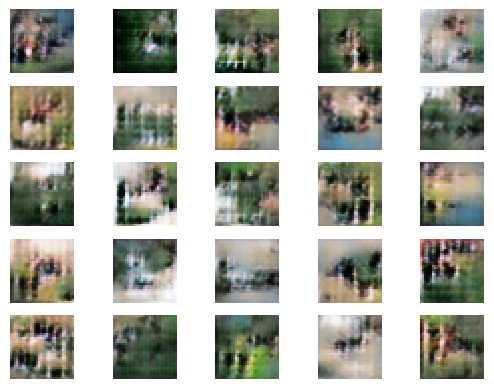

Час навчання епохи 10 - 404.39 сек
Епоха 11 з 20
LEARNING_RATE=0.00010
Ep=11, J=19/195, d_loss1=0.423, d_loss2=0.518, gan_loss=1.384
Ep=11, J=38/195, d_loss1=0.682, d_loss2=0.560, gan_loss=1.249
Ep=11, J=57/195, d_loss1=0.707, d_loss2=0.423, gan_loss=1.477
Ep=11, J=76/195, d_loss1=0.608, d_loss2=0.524, gan_loss=1.545
Ep=11, J=95/195, d_loss1=0.595, d_loss2=0.507, gan_loss=1.425
Ep=11, J=114/195, d_loss1=0.631, d_loss2=0.535, gan_loss=1.559
Ep=11, J=133/195, d_loss1=0.586, d_loss2=0.615, gan_loss=1.433
Ep=11, J=152/195, d_loss1=0.534, d_loss2=0.505, gan_loss=1.326
Ep=11, J=171/195, d_loss1=0.709, d_loss2=0.454, gan_loss=1.389
Ep=11, J=190/195, d_loss1=0.417, d_loss2=0.502, gan_loss=1.477
Точність для реального зображення:  68
Точність для фейкового зображення 68


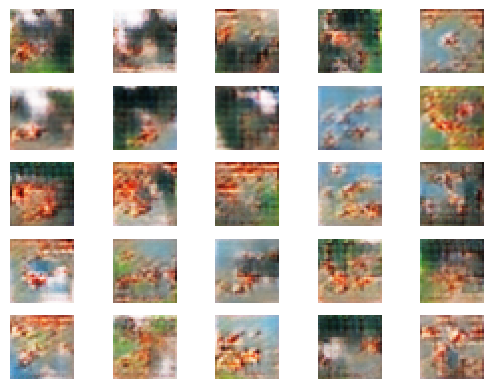

Час навчання епохи 11 - 361.33 сек
Епоха 12 з 20
LEARNING_RATE=0.00010
Ep=12, J=19/195, d_loss1=0.674, d_loss2=0.406, gan_loss=1.427
Ep=12, J=38/195, d_loss1=0.566, d_loss2=0.410, gan_loss=1.423
Ep=12, J=57/195, d_loss1=0.570, d_loss2=0.541, gan_loss=1.414
Ep=12, J=76/195, d_loss1=0.841, d_loss2=0.394, gan_loss=1.454
Ep=12, J=95/195, d_loss1=0.458, d_loss2=0.606, gan_loss=1.204
Ep=12, J=114/195, d_loss1=0.565, d_loss2=0.517, gan_loss=1.423
Ep=12, J=133/195, d_loss1=0.588, d_loss2=0.597, gan_loss=1.301
Ep=12, J=152/195, d_loss1=0.668, d_loss2=0.551, gan_loss=1.406
Ep=12, J=171/195, d_loss1=0.664, d_loss2=0.540, gan_loss=1.452
Ep=12, J=190/195, d_loss1=0.578, d_loss2=0.406, gan_loss=1.692
Точність для реального зображення:  58
Точність для фейкового зображення 73


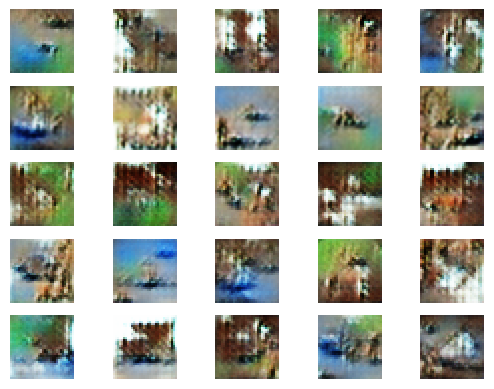

Час навчання епохи 12 - 373.89 сек
Епоха 13 з 20
LEARNING_RATE=0.00010
Ep=13, J=19/195, d_loss1=0.614, d_loss2=0.562, gan_loss=1.393
Ep=13, J=38/195, d_loss1=0.646, d_loss2=0.506, gan_loss=1.483
Ep=13, J=57/195, d_loss1=0.590, d_loss2=0.552, gan_loss=1.406
Ep=13, J=76/195, d_loss1=0.668, d_loss2=0.693, gan_loss=1.299
Ep=13, J=95/195, d_loss1=0.624, d_loss2=0.523, gan_loss=1.378
Ep=13, J=114/195, d_loss1=0.686, d_loss2=0.565, gan_loss=1.159
Ep=13, J=133/195, d_loss1=0.581, d_loss2=0.610, gan_loss=1.151
Ep=13, J=152/195, d_loss1=0.701, d_loss2=0.593, gan_loss=1.136
Ep=13, J=171/195, d_loss1=0.599, d_loss2=0.479, gan_loss=1.282
Ep=13, J=190/195, d_loss1=0.630, d_loss2=0.530, gan_loss=1.406
Точність для реального зображення:  54
Точність для фейкового зображення 82


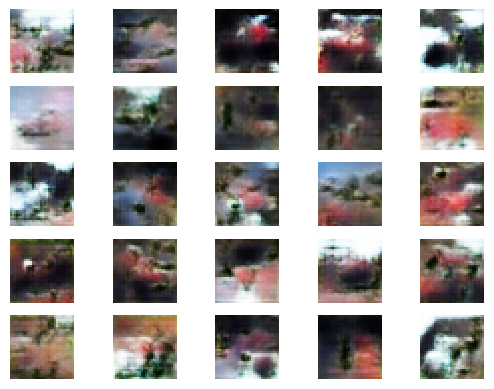

Час навчання епохи 13 - 363.02 сек
Епоха 14 з 20
LEARNING_RATE=0.00010
Ep=14, J=19/195, d_loss1=0.728, d_loss2=0.554, gan_loss=1.167
Ep=14, J=38/195, d_loss1=0.618, d_loss2=0.629, gan_loss=1.181
Ep=14, J=57/195, d_loss1=0.611, d_loss2=0.700, gan_loss=1.171
Ep=14, J=76/195, d_loss1=0.584, d_loss2=0.630, gan_loss=1.291
Ep=14, J=95/195, d_loss1=0.664, d_loss2=0.485, gan_loss=1.399
Ep=14, J=114/195, d_loss1=0.625, d_loss2=0.628, gan_loss=1.133
Ep=14, J=133/195, d_loss1=0.725, d_loss2=0.617, gan_loss=1.159
Ep=14, J=152/195, d_loss1=0.596, d_loss2=0.542, gan_loss=1.252
Ep=14, J=171/195, d_loss1=0.542, d_loss2=0.558, gan_loss=1.234
Ep=14, J=190/195, d_loss1=0.663, d_loss2=0.617, gan_loss=1.131
Точність для реального зображення:  66
Точність для фейкового зображення 84


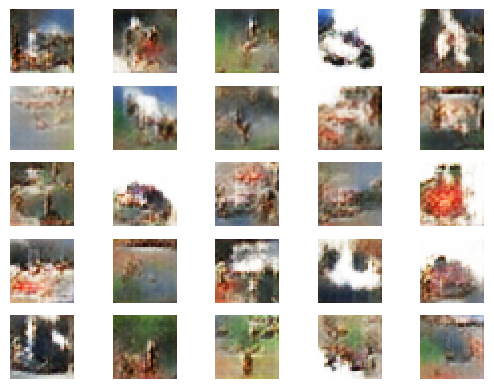

Час навчання епохи 14 - 360.36 сек
Епоха 15 з 20
LEARNING_RATE=0.00010
Ep=15, J=19/195, d_loss1=0.576, d_loss2=0.717, gan_loss=1.071
Ep=15, J=38/195, d_loss1=0.648, d_loss2=0.573, gan_loss=1.267
Ep=15, J=57/195, d_loss1=0.644, d_loss2=0.560, gan_loss=1.200
Ep=15, J=76/195, d_loss1=0.686, d_loss2=0.672, gan_loss=1.080
Ep=15, J=95/195, d_loss1=0.517, d_loss2=0.655, gan_loss=1.394
Ep=15, J=114/195, d_loss1=0.576, d_loss2=0.671, gan_loss=1.176
Ep=15, J=133/195, d_loss1=0.661, d_loss2=0.623, gan_loss=1.013
Ep=15, J=152/195, d_loss1=0.587, d_loss2=0.555, gan_loss=1.091
Ep=15, J=171/195, d_loss1=0.599, d_loss2=0.516, gan_loss=1.289
Ep=15, J=190/195, d_loss1=0.603, d_loss2=0.560, gan_loss=1.187
Точність для реального зображення:  58
Точність для фейкового зображення 80


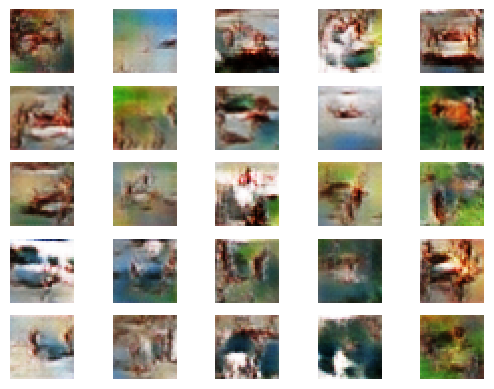

Час навчання епохи 15 - 364.82 сек
Епоха 16 з 20
LEARNING_RATE=0.00010
Ep=16, J=19/195, d_loss1=0.698, d_loss2=0.548, gan_loss=1.132
Ep=16, J=38/195, d_loss1=0.641, d_loss2=0.644, gan_loss=1.080
Ep=16, J=57/195, d_loss1=0.638, d_loss2=0.605, gan_loss=1.109
Ep=16, J=76/195, d_loss1=0.575, d_loss2=0.553, gan_loss=1.186
Ep=16, J=95/195, d_loss1=0.677, d_loss2=0.621, gan_loss=1.062
Ep=16, J=114/195, d_loss1=0.660, d_loss2=0.611, gan_loss=1.041
Ep=16, J=133/195, d_loss1=0.651, d_loss2=0.614, gan_loss=1.100
Ep=16, J=152/195, d_loss1=0.689, d_loss2=0.565, gan_loss=1.110
Ep=16, J=171/195, d_loss1=0.646, d_loss2=0.612, gan_loss=1.025
Ep=16, J=190/195, d_loss1=0.693, d_loss2=0.587, gan_loss=1.200
Точність для реального зображення:  54
Точність для фейкового зображення 87


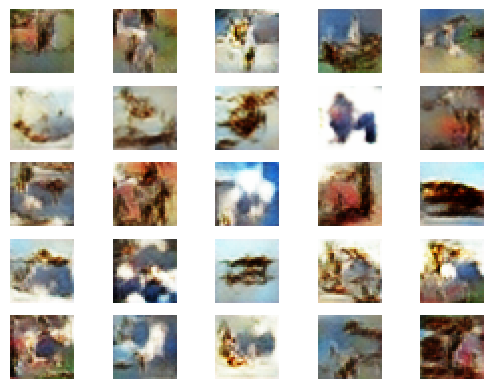

Час навчання епохи 16 - 384.40 сек
Епоха 17 з 20
LEARNING_RATE=0.00010
Ep=17, J=19/195, d_loss1=0.637, d_loss2=0.594, gan_loss=1.010
Ep=17, J=38/195, d_loss1=0.689, d_loss2=0.588, gan_loss=0.984
Ep=17, J=57/195, d_loss1=0.647, d_loss2=0.626, gan_loss=1.041
Ep=17, J=76/195, d_loss1=0.818, d_loss2=0.560, gan_loss=0.999
Ep=17, J=95/195, d_loss1=0.590, d_loss2=0.566, gan_loss=1.141
Ep=17, J=114/195, d_loss1=0.613, d_loss2=0.635, gan_loss=1.033
Ep=17, J=133/195, d_loss1=0.610, d_loss2=0.614, gan_loss=1.159
Ep=17, J=152/195, d_loss1=0.640, d_loss2=0.646, gan_loss=1.047
Ep=17, J=171/195, d_loss1=0.612, d_loss2=0.599, gan_loss=1.019
Ep=17, J=190/195, d_loss1=0.704, d_loss2=0.570, gan_loss=1.092
Точність для реального зображення:  60
Точність для фейкового зображення 80


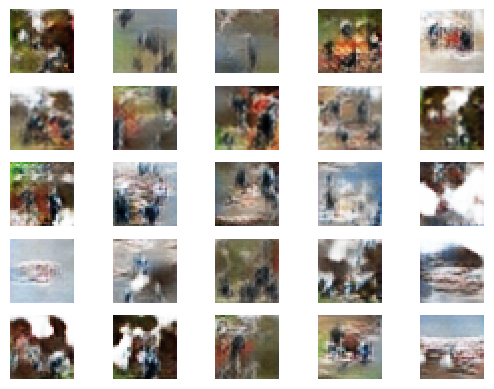

Час навчання епохи 17 - 364.04 сек
Епоха 18 з 20
LEARNING_RATE=0.00010
Ep=18, J=19/195, d_loss1=0.653, d_loss2=0.561, gan_loss=1.045
Ep=18, J=38/195, d_loss1=0.621, d_loss2=0.561, gan_loss=1.119
Ep=18, J=57/195, d_loss1=0.617, d_loss2=0.699, gan_loss=0.977
Ep=18, J=76/195, d_loss1=0.680, d_loss2=0.589, gan_loss=1.042
Ep=18, J=95/195, d_loss1=0.632, d_loss2=0.665, gan_loss=0.919
Ep=18, J=114/195, d_loss1=0.605, d_loss2=0.584, gan_loss=1.061
Ep=18, J=133/195, d_loss1=0.626, d_loss2=0.687, gan_loss=1.098
Ep=18, J=152/195, d_loss1=0.571, d_loss2=0.620, gan_loss=1.037
Ep=18, J=171/195, d_loss1=0.602, d_loss2=0.652, gan_loss=1.009
Ep=18, J=190/195, d_loss1=0.782, d_loss2=0.607, gan_loss=1.011
Точність для реального зображення:  69
Точність для фейкового зображення 86


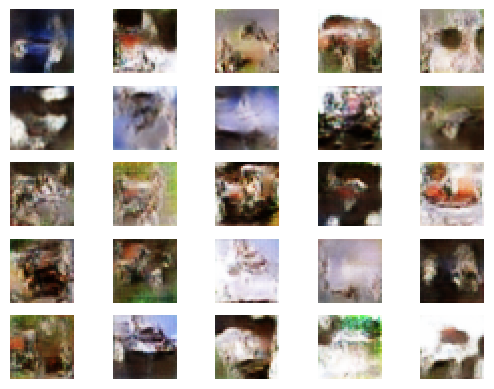

Час навчання епохи 18 - 363.92 сек
Епоха 19 з 20
LEARNING_RATE=0.00010
Ep=19, J=19/195, d_loss1=0.700, d_loss2=0.602, gan_loss=1.028
Ep=19, J=38/195, d_loss1=0.721, d_loss2=0.592, gan_loss=1.007
Ep=19, J=57/195, d_loss1=0.738, d_loss2=0.700, gan_loss=0.968
Ep=19, J=76/195, d_loss1=0.620, d_loss2=0.617, gan_loss=1.025
Ep=19, J=95/195, d_loss1=0.663, d_loss2=0.651, gan_loss=0.981
Ep=19, J=114/195, d_loss1=0.682, d_loss2=0.643, gan_loss=0.913
Ep=19, J=133/195, d_loss1=0.705, d_loss2=0.684, gan_loss=1.105
Ep=19, J=152/195, d_loss1=0.669, d_loss2=0.609, gan_loss=0.902
Ep=19, J=171/195, d_loss1=0.588, d_loss2=0.624, gan_loss=0.917
Ep=19, J=190/195, d_loss1=0.696, d_loss2=0.661, gan_loss=1.009
Точність для реального зображення:  59
Точність для фейкового зображення 79


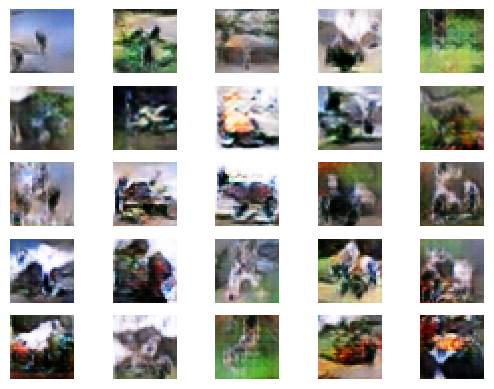

Час навчання епохи 19 - 368.35 сек
Епоха 20 з 20
LEARNING_RATE=0.00010
Ep=20, J=19/195, d_loss1=0.765, d_loss2=0.589, gan_loss=1.037
Ep=20, J=38/195, d_loss1=0.661, d_loss2=0.616, gan_loss=1.002
Ep=20, J=57/195, d_loss1=0.668, d_loss2=0.654, gan_loss=0.922
Ep=20, J=76/195, d_loss1=0.645, d_loss2=0.658, gan_loss=0.895
Ep=20, J=95/195, d_loss1=0.685, d_loss2=0.692, gan_loss=0.917
Ep=20, J=114/195, d_loss1=0.662, d_loss2=0.629, gan_loss=0.937
Ep=20, J=133/195, d_loss1=0.683, d_loss2=0.638, gan_loss=0.944
Ep=20, J=152/195, d_loss1=0.680, d_loss2=0.599, gan_loss=0.961
Ep=20, J=171/195, d_loss1=0.753, d_loss2=0.664, gan_loss=0.882
Ep=20, J=190/195, d_loss1=0.743, d_loss2=0.636, gan_loss=0.946
Точність для реального зображення:  56
Точність для фейкового зображення 73


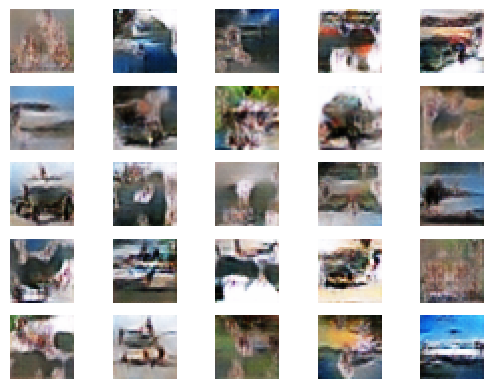

Час навчання епохи 20 - 374.86 сек
Загальний час навчання на 20 епохах - 7297.86 сек


In [50]:
train(gen_model = generator,
      disc_model = discriminator,
      gen_disc_model = gen_disc,
      dataset = train_images,
      input_dim = INPUT_DIM,
      n_epochs = EPOCHS,
      batch_size = BATCH_SIZE,
      to_save=True)

In [51]:
generator.save("generator_final.h5")

/home/vasily/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [52]:
discriminator.save("discriminator_final.h5")

In [53]:
gen_disc.save("gen_disc_final.h5")